## General Setup

In [1]:
import os

import numpy as np

import keras
from keras.applications import mobilenet_v2, imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import tensorflow

Using TensorFlow backend.


In [2]:
np.random.seed(4096)
tensorflow.set_random_seed(4096)

In [3]:
IMAGE_W = 224
IMAGE_H = 224

EPOCHS = 10
INITIAL_LR = 0.0005
BATCH_SIZE = 32

TRAIN_IMAGES_DIRECTORY = '../../Workspace/bad-cat/train_images'

KERAS_MODEL_FILE = 'mobilenet_classifier.h5'
TFLITE_MODEL_FILE = 'mobilenet_classifier.tflite'
LABELS_FILE = 'mobilenet_labels.pickle'

## Setup Image Generators

In [4]:
image_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

training_generator = image_generator.flow_from_directory(
    TRAIN_IMAGES_DIRECTORY,
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = image_generator.flow_from_directory(
    TRAIN_IMAGES_DIRECTORY,
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 23243 images belonging to 4 classes.
Found 5810 images belonging to 4 classes.


In [5]:
labels = [item[0] for item in sorted(training_generator.class_indices.items(), key=lambda item: item[1])]

import pickle
with open(LABELS_FILE, 'wb') as f:
    pickle.dump(labels, f)

## Define Model

In [6]:
mobilenet_model = mobilenet_v2.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_W,IMAGE_H,3)
)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
for layer in mobilenet_model.layers:
    layer.trainable = False

x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(training_generator.num_classes, activation='softmax')(x)

model = Model(inputs=mobilenet_model.input, outputs=x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## Warm Up Model

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = SGD(lr=INITIAL_LR),
    metrics=['accuracy']
)

H = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    steps_per_epoch=training_generator.samples / training_generator.batch_size,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    epochs=3,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
727/726 [==============================] - 235s 324ms/step - loss: 0.9000 - acc: 0.6588 - val_loss: 0.8398 - val_acc: 0.6155
Epoch 2/3
727/726 [==============================] - 229s 315ms/step - loss: 0.5550 - acc: 0.8291 - val_loss: 0.7066 - val_acc: 0.6988
Epoch 3/3
727/726 [==============================] - 236s 325ms/step - loss: 0.3966 - acc: 0.8803 - val_loss: 0.6879 - val_acc: 0.7267


## Train Entire Model

In [10]:
for layer in mobilenet_model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer = SGD(lr=INITIAL_LR),
    metrics=['accuracy']
)

H = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    steps_per_epoch=training_generator.samples / training_generator.batch_size,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    epochs=EPOCHS,
    callbacks=[
        ModelCheckpoint(KERAS_MODEL_FILE, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    ]
)

Epoch 1/10
727/726 [==============================] - 429s 590ms/step - loss: 0.1700 - acc: 0.9560 - val_loss: 0.1701 - val_acc: 0.9368

Epoch 00001: val_acc improved from -inf to 0.93683, saving model to mobilenet_classifier.h5
Epoch 2/10
727/726 [==============================] - 416s 572ms/step - loss: 0.0636 - acc: 0.9873 - val_loss: 0.1964 - val_acc: 0.9272

Epoch 00002: val_acc did not improve from 0.93683
Epoch 3/10
727/726 [==============================] - 420s 577ms/step - loss: 0.0358 - acc: 0.9932 - val_loss: 0.1365 - val_acc: 0.9496

Epoch 00003: val_acc improved from 0.93683 to 0.94957, saving model to mobilenet_classifier.h5
Epoch 4/10
727/726 [==============================] - 421s 579ms/step - loss: 0.0247 - acc: 0.9955 - val_loss: 0.1240 - val_acc: 0.9554

Epoch 00004: val_acc improved from 0.94957 to 0.95542, saving model to mobilenet_classifier.h5
Epoch 5/10
727/726 [==============================] - 417s 574ms/step - loss: 0.0196 - acc: 0.9958 - val_loss: 0.1037 - 

## Export as TFLite Model

In [11]:
converter = tensorflow.contrib.lite.TFLiteConverter.from_keras_model_file(KERAS_MODEL_FILE)
converted_model = converter.convert()
with open(TFLITE_MODEL_FILE, 'wb') as f:
    f.write(converted_model)
    
keras.backend.clear_session()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 266 variables.
INFO:tensorflow:Converted 266 variables to const ops.


## Evaluate Training Results

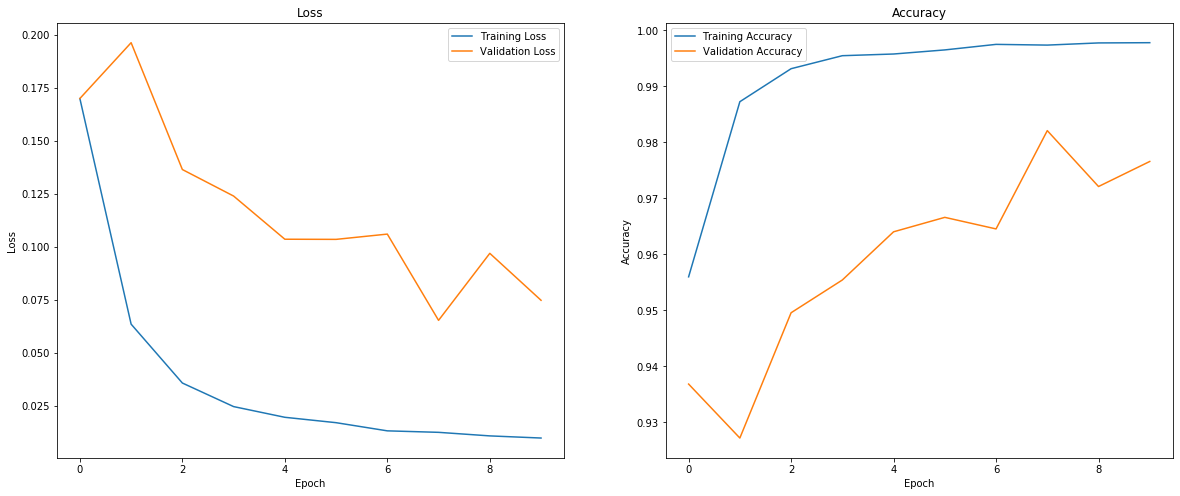

In [15]:
import matplotlib.pyplot as plt

N = np.arange(0, EPOCHS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.plot(N, H.history["loss"], label="Training Loss")
ax1.plot(N, H.history["val_loss"], label="Validation Loss")
ax1.set(title="Loss", xlabel='Epoch', ylabel='Loss')
ax1.legend()

ax2.plot(N, H.history["acc"], label="Training Accuracy")
ax2.plot(N, H.history["val_acc"], label="Validation Accuracy")
ax2.set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax2.legend()

plt.show()

In [13]:
model = keras.models.load_model(KERAS_MODEL_FILE)

predictions = model.predict_generator(validation_generator, steps=validation_generator.samples / validation_generator.batch_size)
predictions = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = validation_generator.class_indices.keys()

import sklearn.metrics as metrics
print(metrics.confusion_matrix(y_true=true_classes, y_pred=predictions))
print(metrics.classification_report(true_classes, predictions))

[[ 697   66    1   26]
 [   0 2263   58    5]
 [   5   39  104   63]
 [  60    0    2 2421]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       790
           1       0.96      0.97      0.96      2326
           2       0.63      0.49      0.55       211
           3       0.96      0.98      0.97      2483

    accuracy                           0.94      5810
   macro avg       0.87      0.83      0.85      5810
weighted avg       0.94      0.94      0.94      5810



In [ ]:
import keract

from keras.preprocessing.image import img_to_array
from PIL import Image

image = Image.open('../../Workspace/bad-cat/train_images/ripley/Cat Cam-20190813-132600-1565659560-82.jpg')
image = image.resize((224, 224))
image = img_to_array(image)
image_arr = np.array(image)
image = image.reshape(1, *image.shape)
image = mobilenet_v2.preprocess_input(image)

model = keras.models.load_model(KERAS_MODEL_FILE)
activations = keract.get_activations(model, image)
keract.display_activations(activations)
keract.display_heatmaps(activations, image_arr)